# Forel Ule calculation test

## Test and compare several FUME algorithms

### Test
* FU cromaticity calibrationFUME: WW2010 used in WHW2013 vs. NWW2013 used in WW2015
* WHW2013 against formulae in Woerd and Wernand (2015, Sensors, Supplementary Information)
* Sensor based empirical hue correction due to subsampling of spectum (WW2015) 
* CMF functions
* Integration method

### Testing datasets:
* 500 hyperspectral simulated global relfectances from marine and freshwater optical types (IOCCG)
https://www.ioccg.org/groups/OCAG_data.html
* 1500+ hyperspectral in situ observations from the Baltic (Qin et al 2017) 
https://doi.org/10.5281/zenodo.5572537
* Also, compare the effect of different CMF tables

### Conclusions
* The FU calibration has the greatest effect, followed by sensor Hue angle correction and choice of CMF function

To use FUME WW2015
```
fume.calc_ForelUle_image(wavelength, 
                         satRrs,
                         sensorcorr=sensor,
                         fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv')
```

To use FUME WHW2013
```
fume.calc_ForelUle_image(wavelength, 
                         satRrs,
                         sensorcorr=None,
                         fucalibration='data/hue_angle_limits_NWW2013.csv')
```


WW2010

*Wernand, M. R., and van der Woerd, H. J. 2010. Spectral analysis of the Forel-Ule ocean colour comparator scale. Journal of the European Optical Society, 5.*

WHW2013

*M.R. Wernand, A. Hommersom, and H. J. van der Woerd, 2013. MERIS-based ocean colour classification with the discrete Forel–Ule scale. Ocean Science.* doi:10.5194/os-9-477-2013

NWW2013

*Novoa, S., Wernand, M. R., and Woerd, H. J. van der. 2013. The Forel-Ule scale revisited spectrally: preparation protocol, transmission measurements and chromaticity. Journal of the European Optical Society: Rapid Publications, 8: 13057.* https://www.jeos.org/index.php/jeos_rp/article/view/13057.

WW2015

*Hendrik J. van der Woerd and Marcel R. Wernand 2015. True Colour Classification of Natural Waters with Medium-Spectral Resolution Satellites: SeaWiFS, MODIS, MERIS and OLCI. Sensors, 15, 25663-25680.*

*Qin, P., Simis, S.G.H., & Tilstone, G.H. (2017). Radiometric validation of atmospheric correction for MERIS in the Baltic Sea based on continuous observations from ships and AERONET-OC. Remote Sensing of Environment, 200, 263-280*


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import math
import numpy as np
import fume

In [2]:
sensor='olci'

satwavelength = {'meris':  [412.5,442.5,490,510,560,620,665,681.25,708],
                 'olci':   [400,412.5,442.5,490,510,560,620,665,673.75,681.25,708.75],
                 'modis':  [412.5,443,490,531,551,667,678],
                 'seawifs':[413,443,490,510,555,670]}

satwavelength = satwavelength[sensor]

## Read hyperspectral data and interpolate to Satellite bands

### Synthetic global data IOCCG 

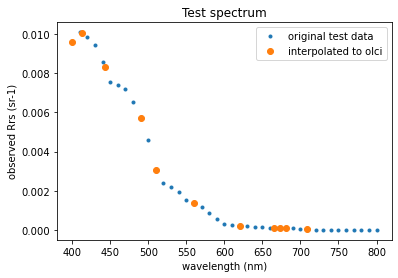

In [3]:
# https://www.ioccg.org/groups/OCAG_data.html
iobs = 1
obs = pd.read_csv(filepath_or_buffer = "data/IOP_AOP_Sun30.Rrs.csv")
obswavelength = [int(name) for name in list(obs.columns)]
obsRrs = obs.iloc[iobs].values

# retrieving the reflectance values for satellite band frequencies
satRrs = interp1d(obswavelength, obsRrs, kind = 'linear')(satwavelength)

plt.plot(obswavelength,obsRrs,'.',label='original test data')
plt.plot(satwavelength,satRrs,'o',label='interpolated to '+sensor)
plt.ylabel('observed Rrs (sr-1)')
plt.xlabel('wavelength (nm)')
plt.title('Test spectrum')
plt.legend()


### In situ hyperspectral from the Baltic
https://doi.org/10.5281/zenodo.5572537

C:\Users\tams00\AppData\Local\mambaforge\envs\gitm-utils\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


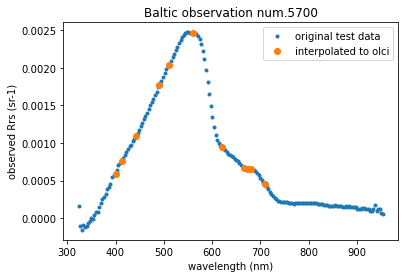

In [4]:
obs2 = pd.read_csv(sep = "\,", filepath_or_buffer = "data/rrs-bal-filtered.csv").iloc[:,4:]
obs2band = [int(name.split('_')[1]) for name in obs2.columns]
obs2wavelength = [int(name.split('_')[-1])/10 for name in obs2.columns]


# Plot single spectrum
iobs=5700
obs2Rrs = obs2.iloc[iobs].values
# retrieving the reflectance values for OLCI band frequencies
sat2Rrs = interp1d(obs2wavelength, obs2Rrs, kind = 'linear')(satwavelength)

plt.plot(obs2wavelength,obs2Rrs,'.',label='original test data')
plt.plot(satwavelength,sat2Rrs,'o',label='interpolated to '+sensor)
plt.ylabel('observed Rrs (sr-1)')
plt.xlabel('wavelength (nm)')
plt.title(f'Baltic observation num.{iobs}')
plt.legend();

## Auxiliary plotting functions

In [5]:
def fububble(xseries,yseries):

    fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
    ax=axs
    
    hist2d, xedges, yedges = np.histogram2d(xseries, yseries, bins=range(0,22))
    # bin limits have n+1 size
    xx,yy = np.meshgrid(xedges[1:],yedges[1:])
    # find x,y  and count for each bin
    xclass = pd.Series(xx[hist2d > 0],name=xseries.name)
    yclass = pd.Series(yy[hist2d > 0],name=yseries.name)
    numpoints = pd.Series(hist2d[hist2d>0],name='count')
    
    df = pd.DataFrame([xclass,yclass,numpoints])
    plt.plot([0, 21], [0, 21], '--',color='k',alpha=0.2)
    sns.scatterplot(data=df, x=xclass, y=yclass, size=numpoints,legend='auto', sizes=(20,300),alpha=0.7)#, sizes={'1':100,'10':100,'100':1000})

    plt.ylim(0, 21)
    plt.xlim(0, 21)
    
    return ax

In [6]:
def FUscatter(x,y):
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    plt.plot(x, y,'.')
    type(ax)
    ax.plot([0, 21], [0, 21], '--',color='k', alpha=0.3)
    df = pd.DataFrame((x,y)).T
    sns.scatterplot( data=df,x=x.name,y=y.name)
    plt.xlim(0, 21)
    plt.ylim(0, 21)
    plt.xticks(np.arange(0, 21+1, 1))
    plt.yticks(np.arange(0, 21+1, 1))
    
    return ax

## Compare FUME v1 (Woerd&Wernand 2013) with Woer&Wernand 2015

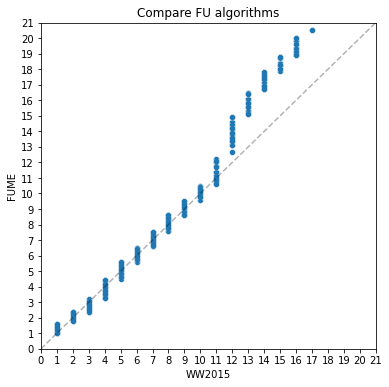

In [7]:
from importlib import reload
fume = reload(fume)

fus_ww2015 = []
fus_fume = []

from timeit import default_timer as timer

start = timer()
for iobs in range(0,500):

    obsRrs = obs.iloc[iobs,:].values

    # retrieving the reflectance values for OLCI band frequencies
    satRrs = interp1d(obswavelength, obsRrs, kind = 'linear')(satwavelength)

    #Calculate Forel Ule
    
    fu_ww2015 = fume.calc_fu_WW2015(satwavelength,satRrs,sensor)
    fu_fume = fume.calc_ForelUle_image(np.array(satwavelength), 
                                       np.expand_dims(np.array(satRrs), axis=[1,2]),
                                       sensorcorr=sensor,
                                       fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv'
                                      )[0,0]
    
    fus_ww2015.append(fu_ww2015)
    fus_fume.append(fu_fume)

ax = FUscatter( pd.Series(fus_ww2015,name='WW2015'), pd.Series(fus_fume,name='FUME'))
ax.set_title('Compare FU algorithms');

This is consistent with the differences in chromaticity plotted in colour space in Novoa et at 2013.

<img src="data/FU_Novoa_etal2013.png" alt="Fig. 8" width="500"/>

## Compare algorithms, using same FU calibration

Text(0.5, 1.0, 'Differnt algorithms, same FU calibration')

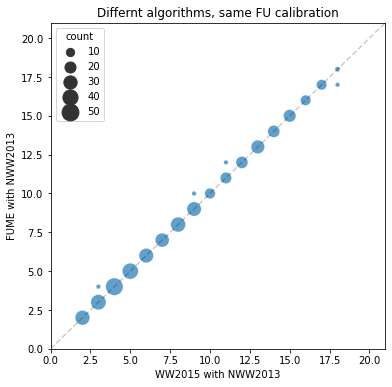

In [8]:
fus_ww2015 = []
fus_fume = []

from timeit import default_timer as timer

start = timer()
for iobs in range(0,500):

    obsRrs = obs.iloc[iobs,:].values

    # retrieving the reflectance values for OLCI band frequencies
    satRrs = interp1d(obswavelength, obsRrs, kind = 'linear')(satwavelength)

    #Calculate Forel Ule
    
    fu_ww2015 = fume.calc_fu_WW2015(satwavelength,satRrs, sensor)
    fu_fume = fume.calc_ForelUle_image(np.array(satwavelength), 
                                       np.expand_dims(np.array(satRrs), axis=[1,2]),
                                       sensorcorr = sensor,
                                       fucalibration='data/hue_angle_limits_NWW2013.csv'
                                      )[0,0]
    
    fus_ww2015.append(fu_ww2015)
    fus_fume.append(fu_fume)


ax = fububble(pd.Series(fus_ww2015,name='WW2015 with NWW2013'),
              pd.Series(fus_fume,name='FUME with NWW2013'))
ax.set_title('Differnt algorithms, same FU calibration')

## Effect of CFM functions

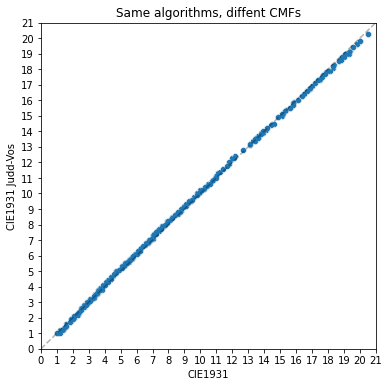

In [9]:
cmf='data/FUI_CIE1931_JV.tsv'

fus_fumecmf1 = []
fus_fumecmf2 = []

from timeit import default_timer as timer

start = timer()
for iobs in range(0,500):

    obsRrs = obs.iloc[iobs].values

    # retrieving the reflectance values for OLCI band frequencies
    satRrs = interp1d(obswavelength, obsRrs, kind = 'linear')(satwavelength)

    #Calculate Forel Ule
    
    fu_fumecmf1 = fume.calc_ForelUle_image(np.array(satwavelength), 
                                           np.expand_dims(np.array(satRrs),axis=[1,2]),
                                           sensorcorr=sensor,
                                           cmf='data/FUI_CIE1931.tsv',
                                           fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv'
                                          )[0,0]
    fu_fumecmf2 = fume.calc_ForelUle_image(np.array(satwavelength), 
                                           np.expand_dims(np.array(satRrs), axis=[1,2]),
                                           sensorcorr=sensor,
                                           cmf='data/FUI_CIE1931_JV.tsv',
                                           fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv'
                                          )[0,0]
    
    fus_fumecmf1.append(fu_fumecmf1)
    fus_fumecmf2.append(fu_fumecmf2)
    
ax = FUscatter( pd.Series(fus_fumecmf1,name='CIE1931'), pd.Series(fus_fumecmf2,name='CIE1931 Judd-Vos'))
ax.set_title('Same algorithms, diffent CMFs');

## Effect of Sensor Hue angle correction

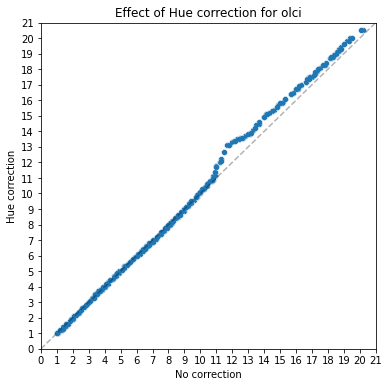

In [10]:
fus_fumenocorr = []
fus_fumecorr = []

from timeit import default_timer as timer

start = timer()
for iobs in range(0,500):

    obsRrs = obs.iloc[iobs].values

    # retrieving the reflectance values for OLCI band frequencies
    satRrs = interp1d(obswavelength, obsRrs, kind = 'linear')(satwavelength)

    #Calculate Forel Ule
    
    fu_fumenocorr = fume.calc_ForelUle_image(np.array(satwavelength), 
                                             np.expand_dims(np.array(satRrs), axis=[1,2]),
                                             sensorcorr=None,
                                             cmf='data/FUI_CIE1931.tsv',
                                             fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv'                                             
                                            )[0,0]
    fu_fumecorr = fume.calc_ForelUle_image(np.array(satwavelength), 
                                           np.expand_dims(np.array(satRrs), axis=[1,2]),
                                           sensorcorr=sensor,
                                           cmf='data/FUI_CIE1931.tsv',
                                           fucalibration='data/hue_angle_limits_WW2010_decimalFU.csv'                                        
                                          )[0,0]
    
    fus_fumenocorr.append(fu_fumenocorr)
    fus_fumecorr.append(fu_fumecorr)

    
ax = FUscatter( pd.Series(fus_fumenocorr,name='No correction'), pd.Series(fus_fumecorr,name='Hue correction'))
ax.set_title(f'Effect of Hue correction for {sensor}');